# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>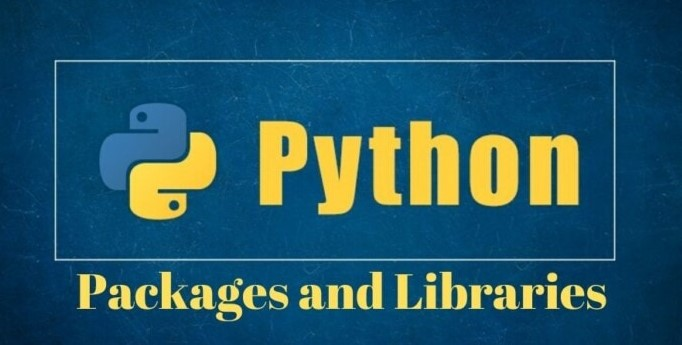

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [4]:
def convertMillis(sec):
    millis = int((sec*1000)%1000)
    seconds= int((sec//1)%60)
    minutes= int(sec//60%60)
    hours=int(sec//60//60)%24
    days = int(sec//60//60//24)
    if days != 0:
        return "%dD : %dh : %dmin : %ds" % (days,hours, minutes, seconds)
    
    if hours != 0:
        return "%dh : %dmin : %ds" % (hours, minutes, seconds)
    
    if hours != 0:
        return "%dmin : %ds" % ( minutes, seconds)
    
    else: 
        return "%ds" % ( seconds )

In [5]:
convertMillis(26.023)

'26s'

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>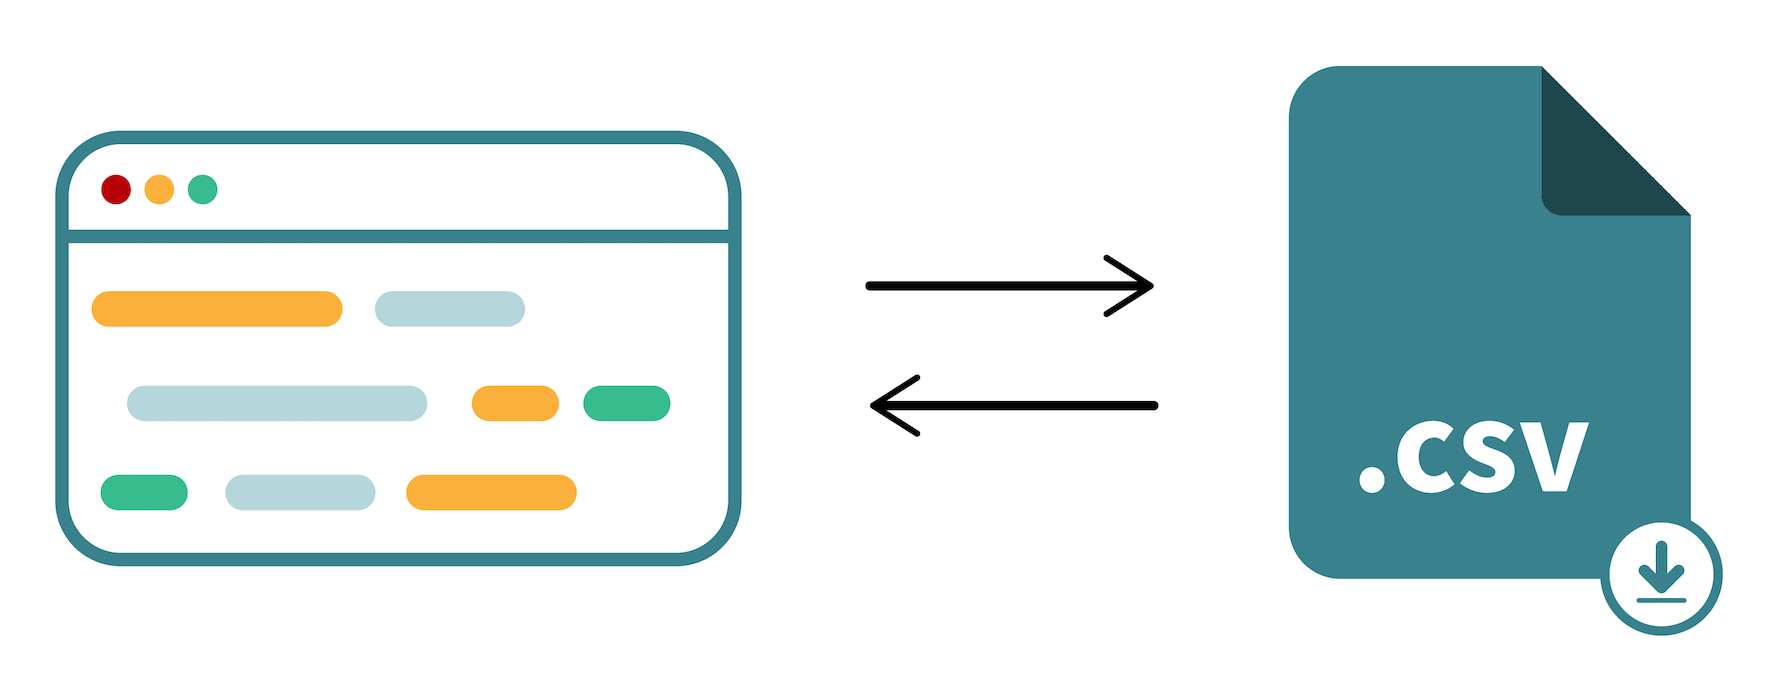

In [6]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [7]:
def clean_data1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    data = data[data['CODE_GENDER'] != 'XNA']

    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        data[bin_feature], uniques = pd.factorize(data[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    return data

In [8]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [9]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [10]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [11]:
df.shape

(307507, 127)

</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>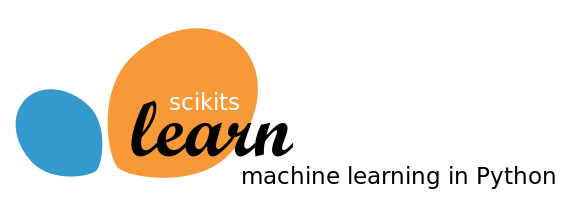

In [12]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate


# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>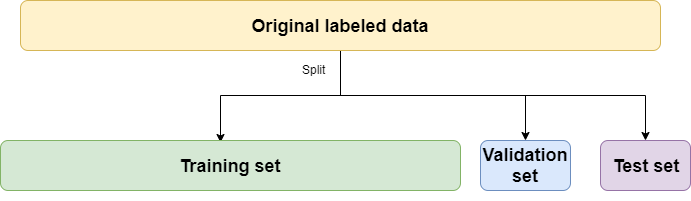

In [13]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 125 colonnes
Le dataset Test se compose de: 46126 lignes et 125 colonnes
Le dataset Validation se compose de: 46127 lignes et 125 colonnes


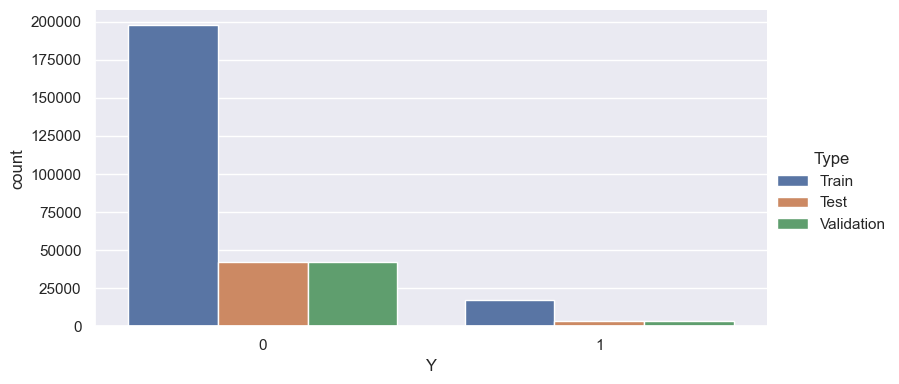

In [14]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [15]:
X_train.dtypes

NAME_CONTRACT_TYPE      object
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 125, dtype: object

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Columns: 125 entries, NAME_CONTRACT_TYPE to PAYMENT_RATE
dtypes: float64(71), int64(41), object(13)
memory usage: 206.9+ MB


</Br>

</Br>

</Br>

## <a name="C33"><font color='green'>III.3 Création pipeline preprocessing data</font></a>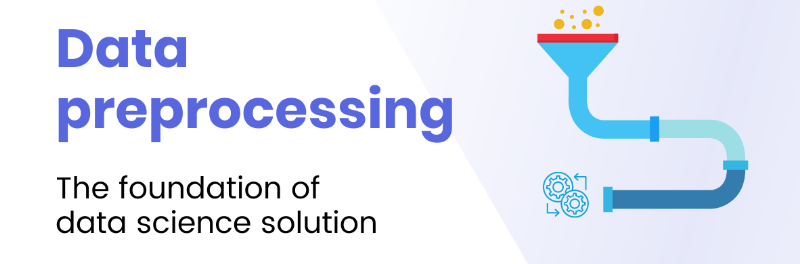

In [18]:

def intermediaire_pipe_pretraitement(X_train,model):
    """
    Fonction qui crée un pipeline, en prétraitant les données en amont puis
    en appliquant un model à la fin

    Args:
        X_train (pandas.core.frame.DataFrame): Training Dataset.
        model (type): model de type sklearn. C'est à dire possedant la méthode fit

    Returns:
        type: Description de la valeur de retour.

    Raises:
        ErrorType: Description de l'erreur éventuellement levée.

    Examples:
        Exemples d'utilisation de la fonction.
    """    
    #Numerical featues
    numeric_features = make_column_selector(dtype_include=np.float64)
    numeric_transformer = Pipeline(
        steps=[('impNumerical', SimpleImputer(strategy="median")) ]
    )

    #Discretes features
    discret_features = make_column_selector(dtype_include=np.int64)
    discret_transformer = Pipeline(
        steps=[('impDiscret', SimpleImputer(strategy = 'most_frequent')) ]
    )

    # categorials features
    categorical_features = make_column_selector(dtype_include="object")
    categorical_transformer = Pipeline(
        steps=[
            ('impCat', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore',sparse=False)),
        ])

    # columntransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_transformer, numeric_features),
            ("disc", discret_transformer, discret_features),
            ("cat",  categorical_transformer, categorical_features),
        ])

    # pipeline
    intermediaire_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model",model)]
    )
    
    return intermediaire_pipeline

In [19]:
# Entraîner le pipeline sur les données d'entraînement
intermediaire_pipeline = intermediaire_pipe_pretraitement( X_train,StandardScaler() )
    
# Application pipeline    
X_train_pt = pd.DataFrame(intermediaire_pipeline.fit_transform(X_train),
                          columns=intermediaire_pipeline.get_feature_names_out()
                         )

In [20]:
intermediaire_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001891C5CCC10>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001891C5DC070>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001891C5DC160>)])),
                ('model', StandardScaler())])

In [21]:
X_train_pt.head()

,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__OWN_CAR_AGE,num__CNT_FAM_MEMBERS,num__EXT_SOURCE_1,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,1.111520,-0.135154,-0.119380,-0.240315,0.309525,0.453656,1.022546,0.973500,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.100237,-0.649958,-0.288185,-0.544561,0.309525,-2.357397,1.294713,-0.006215,-0.168448,0.104088,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,0.505641,-0.017281,-0.306182,-0.240315,1.830912,0.876951,-0.570118,-1.265848,0.928981,-0.693097,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,1.515439,-0.764348,0.301389,-0.727109,-0.012079,-1.479469,0.557758,-0.985929,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,0.182506,1.053627,0.639929,0.854973,-0.716342,0.852629,-0.014987,-0.146174,0.928981,0.012651,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [22]:
X_train_pt.filter(regex='^cat', axis=1).head()

,cat__NAME_CONTRACT_TYPE_Revolving loans,cat__NAME_TYPE_SUITE_Family,cat__NAME_TYPE_SUITE_Group of people,cat__NAME_TYPE_SUITE_Other_A,cat__NAME_TYPE_SUITE_Other_B,"cat__NAME_TYPE_SUITE_Spouse, partner",cat__NAME_TYPE_SUITE_Unaccompanied,cat__NAME_INCOME_TYPE_Commercial associate,cat__NAME_INCOME_TYPE_Maternity leave,cat__NAME_INCOME_TYPE_Pensioner,...,cat__FONDKAPREMONT_MODE_reg oper spec account,cat__HOUSETYPE_MODE_specific housing,cat__HOUSETYPE_MODE_terraced house,cat__WALLSMATERIAL_MODE_Mixed,cat__WALLSMATERIAL_MODE_Monolithic,cat__WALLSMATERIAL_MODE_Others,cat__WALLSMATERIAL_MODE_Panel,"cat__WALLSMATERIAL_MODE_Stone, brick",cat__WALLSMATERIAL_MODE_Wooden,cat__EMERGENCYSTATE_MODE_Yes
0,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
1,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
2,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,1.814349,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
3,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,-0.195523,0.480435,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585
4,-0.324055,-0.387587,-0.030035,-0.053572,-0.076118,5.114485,-2.081448,-0.551162,-0.003733,-0.467432,...,-0.202089,-0.070547,-0.062964,-0.087809,-0.076641,-0.072968,0.618344,-0.516386,-0.133461,-0.088585


In [23]:
del X_train_pt
gc.collect()

3950

## <a name="C33"><font color='green'>III.3 Comparaison performance des différents Models</font></a>

In [24]:
score_auc = dict()

### <a name="C331"><font color='green'>III.3.1 Dummy Estimateur</font></a>

In [25]:
%%time
# Use the copy module of Python for deep copy operations
dummy_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
dummy_pipe.steps.append(['dummy',dummy.DummyClassifier(strategy='most_frequent')])
score_auc['dummyEstimator'] = cross_validate(dummy_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['dummyEstimator']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 50.00%
L'entrainement s'exécute en moyenne en : 4s
CPU times: total: 938 ms
Wall time: 7.32 s


### <a name="C332"><font color='green'>III.3.2 Logistic Regression</font></a>

In [26]:
%%time
# Use the copy module of Python for deep copy operations
reg_raw_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
reg_raw_pipe.steps.append(['reglog',LogisticRegression(max_iter = 20000)])

#reg_raw_pipe.fit(X_train, y_train)
score_auc['RegLog_Raw'] = cross_validate(reg_raw_pipe, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Raw']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.55%
L'entrainement s'exécute en moyenne en : 39s
CPU times: total: 656 ms
Wall time: 45.8 s


### <a name="C333"><font color='green'>III.3.3 Adaboost</font></a>

In [27]:
%%time
# Use the copy module of Python for deep copy operations
Ada_pipe = deepcopy(intermediaire_pipeline)
Ada_pipe.steps.append(['Adaboost',AdaBoostClassifier()])

#Compute AUC score
score_auc['Adaboost'] = cross_validate(Ada_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Adaboost']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.49%
L'entrainement s'exécute en moyenne en : 24s
CPU times: total: 734 ms
Wall time: 1min 29s


### <a name="C334"><font color='green'>III.3.4 Random Forest</font></a>

In [28]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['RandomForest',RandomForestClassifier(n_jobs=-1)])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 70.64%
L'entrainement s'exécute en moyenne en : 3s
CPU times: total: 750 ms
Wall time: 1min 7s


### <a name="C335"><font color='green'>III.3.5  HistGradientBoostingClassifier</font></a>

In [29]:
%%time
# Use the copy module of Python for deep copy operations
HistGB_pipe = deepcopy(intermediaire_pipeline)
HistGB_pipe.steps.append(['HistGB',HistGradientBoostingClassifier()])

#Compute AUC score
score_auc['HistGradientBoosting'] = cross_validate(HistGB_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGradientBoosting']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.79%
L'entrainement s'exécute en moyenne en : 31s
CPU times: total: 734 ms
Wall time: 37 s


### <a name="C336"><font color='green'>III.3.6 lightGBM</font></a>

In [30]:
%%time

lgbmc = LGBMClassifier(nthread=4,)

# Use the copy module of Python for deep copy operations
LGBM_pipe = deepcopy(intermediaire_pipeline)
LGBM_pipe.steps.append(['LightGBM',lgbmc])

#Compute AUC score
score_auc['LightGBM'] = cross_validate(LGBM_pipe,X_train, y_train,cv = 5, n_jobs = 3, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['LightGBM']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.85%
L'entrainement s'exécute en moyenne en : 7s
CPU times: total: 766 ms
Wall time: 18.2 s


### <a name="C337"><font color='green'>III.3.7 Gradient Boosting</font></a>

In [32]:
%%time
# Use the copy module of Python for deep copy operations
GradientBoosting_pipe = deepcopy(intermediaire_pipeline)
GradientBoosting_pipe.steps.append(['GradientBoosting',GradientBoostingClassifier()])

#Compute AUC score
score_auc['GradientBoosting'] = cross_validate(GradientBoosting_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['GradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['GradientBoosting']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.43%
L'entrainement s'exécute en moyenne en : 1691.449
CPU times: total: 859 ms
Wall time: 5min 42s


### <a name="C338"><font color='green'>III.3.8 Linear Discriminant Analysis</font></a>

In [33]:
%%time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Use the copy module of Python for deep copy operations
LDA_pipe = deepcopy(intermediaire_pipeline)
LDA_pipe.steps.append(['DiscriminantAnalysis',LinearDiscriminantAnalysis()])

#Compute AUC score
score_auc['Discriminant Analysis'] = cross_validate(LDA_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Discriminant Analysis']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['Discriminant Analysis']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.50%
L'entrainement s'exécute en moyenne en : 97.227
CPU times: total: 891 ms
Wall time: 21.5 s


### <a name="C339"><font color='green'>III.3.9 Perceptron</font></a>

In [37]:
%%time

from sklearn.linear_model import Perceptron
# Use the copy module of Python for deep copy operations
Perceptron_pipe = deepcopy(intermediaire_pipeline)
Perceptron_pipe.steps.append(['Perceptron',Perceptron(eta0=0.001,penalty='elasticnet',
                                                      max_iter = 100000,
                                                      early_stopping = True,
                                                      validation_fraction = 0.3,
                                                      n_jobs=-1,n_iter_no_change=10,
                                                      class_weight = 'balanced'
                                                     )])

#Compute AUC score
score_auc['Perceptron'] = cross_validate(Perceptron_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Perceptron']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Perceptron']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 62.02%
L'entrainement s'exécute en moyenne en : 41.8615
CPU times: total: 672 ms
Wall time: 11.7 s


### <a name="C3310"><font color='green'>III.3.10 Passive Aggressive Classifier</font></a>

In [39]:
%%time

from sklearn.linear_model import PassiveAggressiveClassifier
# Use the copy module of Python for deep copy operations
PAC_pipe = deepcopy(intermediaire_pipeline)
PAC_pipe.steps.append(['Passive Aggressive',PassiveAggressiveClassifier(
    max_iter = 100000,
    early_stopping = True,
    validation_fraction = 0.3,
    n_jobs=-1,n_iter_no_change=10, 
    tol=1e-3)])

#Compute AUC score
score_auc['Passive Aggressive'] = cross_validate(PAC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Passive Aggressive']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Passive Aggressive']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 61.23%
L'entrainement s'exécute en moyenne en : 33.8566
CPU times: total: 688 ms
Wall time: 8.65 s


### <a name="C3311"><font color='green'>III.3.11 KNeighbors Classifier</font></a>

In [40]:
%%time

from sklearn.neighbors import KNeighborsClassifier
# Use the copy module of Python for deep copy operations
KNeighbors_pipe = deepcopy(intermediaire_pipeline)
KNeighbors_pipe.steps.append(['KNeighbors',KNeighborsClassifier(n_neighbors=5)])

#Compute AUC score
score_auc['KNeighbors'] = cross_validate(KNeighbors_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['KNeighbors']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['KNeighbors']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 56.53%
L'entrainement s'exécute en moyenne en : 21.8409
CPU times: total: 688 ms
Wall time: 1min 36s


### <a name="C3312"><font color='green'>III.3.12 Multi-Layer Perceptron Classifier</font></a>

In [49]:
%%time

from sklearn.neural_network import MLPClassifier
# Use the copy module of Python for deep copy operations
MLPC_pipe = deepcopy(intermediaire_pipeline)
MLPC_pipe.steps.append(['MLPClassifier',MLPClassifier(
    hidden_layer_sizes = (128,128,),
    activation = 'tanh',
    learning_rate = 'adaptive',
    max_iter = 10000,early_stopping=True,
    validation_fraction = 0.3,
    alpha=0.2
)])

#Compute AUC score
score_auc['MLPClassifier'] = cross_validate(MLPC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['MLPClassifier']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['MLPClassifier']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.05%
L'entrainement s'exécute en moyenne en : 5s
CPU times: total: 828 ms
Wall time: 45.8 s


### <a name="C3313"><font color='green'>III.3.13 Fit modeles</font></a>

#### <a name="C33131"><font color='green'>III.3.13.1 Fit modeles Raw</font></a>

In [51]:

for clf in [dummy_pipe,reg_raw_pipe,Ada_pipe,RF_pipe,HistGB_pipe,LGBM_pipe,GradientBoosting_pipe,MLPC_pipe]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                 )
         )
    print("\n")

Entrainement du model: DummyClassifier en cours!
Scores obtenus sur les datasets
 Train: 50.0000% | Validation : 50.0000% | Test : 50.0000%


Entrainement du model: LogisticRegression en cours!
Scores obtenus sur les datasets
 Train: 75.0086% | Validation : 75.1333% | Test : 74.7945%


Entrainement du model: AdaBoostClassifier en cours!
Scores obtenus sur les datasets
 Train: 75.0545% | Validation : 75.1408% | Test : 75.0686%


Entrainement du model: RandomForestClassifier en cours!
Scores obtenus sur les datasets
 Train: 100.0000% | Validation : 71.4127% | Test : 71.4853%


Entrainement du model: HistGradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 79.7643% | Validation : 76.3886% | Test : 76.2884%


Entrainement du model: LGBMClassifier en cours!
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Scores obtenus sur les datasets
 Train: 80.8394% | Validation : 76.6873% | Test : 76.4618%


Entrain

#### <a name="C33132"><font color='green'>III.3.13.2 Search Best modeles</font></a>

In [202]:
from sklearn.model_selection import GridSearchCV

In [208]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [229]:
%%time
## RandomForest
param_grid = {"RandomForest__max_depth": [ None], 
              "RandomForest__min_samples_split": [75,100], 
              'RandomForest__n_estimators': [250,300],
              "RandomForest__max_features":[7,8,9,11,16]}

RF_grid = HalvingGridSearchCV(RF_pipe, param_grid, 
                             resource='n_samples',
                             min_resources=2000, max_resources=100000,
                             cv=5,n_jobs=-1,scoring = 'roc_auc',
                             random_state=971).fit(X_train,y_train)
RF_grid.best_params_  

CPU times: total: 2min 45s
Wall time: 3min 25s


{'RandomForest__max_depth': None,
 'RandomForest__max_features': 7,
 'RandomForest__min_samples_split': 75,
 'RandomForest__n_estimators': 300}

In [236]:
print("Score de base: {:.3%}, \nScore après GridSearch {:.3%}"\
      .format( np.round(roc_auc_score(y_test, RF_pipe.predict_proba(X_test)[:, 1]),5),
               np.round(roc_auc_score(y_test, RF_grid.predict_proba(X_test)[:, 1]),5)) 
     )

Score de base: 71.656%, 
Score après GridSearch 73.526%


In [260]:
%%time
### Adaboost
param_grid = {"Adaboost__algorithm": [ 'SAMME' ], 
              "Adaboost__n_estimators":[300,],
              "Adaboost__learning_rate":[0.25,0.28,0.3],
             }

Ada_grid = HalvingGridSearchCV(Ada_pipe, param_grid, 
                             resource='n_samples',
                             min_resources=2000, max_resources=100000,
                             cv=5,n_jobs=-1,scoring = 'roc_auc',
                             random_state=971).fit(X_train,y_train)
Ada_grid.best_params_  

CPU times: total: 6min 56s
Wall time: 7min 14s


{'Adaboost__algorithm': 'SAMME',
 'Adaboost__learning_rate': 0.3,
 'Adaboost__n_estimators': 300}

In [262]:
Ada_best = deepcopy(intermediaire_pipeline)
Ada_best.steps.append(['Adaboost',AdaBoostClassifier(**{'algorithm': 'SAMME','learning_rate': 0.3,'n_estimators': 300} )])
Ada_best.fit(X_train,y_train)

print("Score de base: {:.3%}, \nScore après GridSearch {:.3%}"\
      .format( np.round(roc_auc_score(y_test, Ada_pipe.predict_proba(X_test)[:, 1]),5),
               np.round(roc_auc_score(y_test, Ada_best.predict_proba(X_test)[:, 1]),5)) 
     )

Score de base: 75.069%, 
Score après GridSearch 75.128%


In [273]:
%%time
### HistGradientBoostig
param_grid = {"HistGB__learning_rate": [ 0.1,0.2,0.3 ], 
              "HistGB__max_iter": [ 50,100,200 ], 
              "HistGB__max_leaf_nodes": [ 15,31,50,100 ], 
              "HistGB__max_bins": [ 127,255 ], 
              #"HistGB__categorical_features": [col for col in Ada_best[:-1].get_feature_names_out() if 'cat__' in col], 
             }

HistGB_grid = HalvingGridSearchCV(HistGB_pipe, param_grid, 
                             resource='n_samples',
                             min_resources=2000, max_resources=100000,
                             cv=5,n_jobs=-1,scoring = 'roc_auc',
                             random_state=971).fit(X_train,y_train)
HistGB_grid.best_params_  

PicklingError: Could not pickle the task to send it to the workers.

In [274]:
HistGB_best = deepcopy(intermediaire_pipeline)
HistGB_best.steps.append(['HistGB',HistGradientBoostingClassifier(**dict((key.replace('HistGB__',''), value) for (key, value) in HistGB_grid.best_params_.items()) )])
HistGB_best.fit(X_train,y_train)

print("Score de base: {:.3%}, \nScore après GridSearch {:.3%}"\
      .format( np.round(roc_auc_score(y_test, HistGB_pipe.predict_proba(X_test)[:, 1]),5),
               np.round(roc_auc_score(y_test, HistGB_best.predict_proba(X_test)[:, 1]),5)) 
     )

NameError: name 'HistGB_grid' is not defined

In [ ]:
## tester
{"Adaboost__algorithm": [ 'SAMME','SAMME.R' ], "Adaboost__n_estimators":[20,50,100,200],"Adaboost__learning_rate":[0.1,0.5,1,10,20],
             }

Wall time: 3min 57s
{'Adaboost__algorithm': 'SAMME.R', 'Adaboost__learning_rate': 0.1, 'Adaboost__n_estimators': 20}

### <a name="C34"><font color='green'>III.4 Comparaison des modeles</font></a>

In [183]:
pd.DataFrame(score_auc).applymap(lambda x: np.round(x.mean(),5) )\
.T.sort_values(by = 'test_score', ascending = False)

,fit_time,score_time,test_score
LightGBM,7.31765,0.40269,0.75846
HistGradientBoosting,32.36601,1.50934,0.75768
GradientBoosting,334.75364,0.50932,0.75432
RegLog_MaxIter20000,21.00093,0.28427,0.74550
RegLog_Raw,15.45648,0.41369,0.74547
Adaboost,56.89573,1.52914,0.74492
LightGBM_v2,172.59470,35.39718,0.74213
RandomForest,77.04087,1.43212,0.70623
dummyEstimator,4.10112,0.40769,0.50000


In [ ]:
# lightgbm est le meilleur model

In [280]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
def generate_auc_roc_curve(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.steps[-1][1].__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass

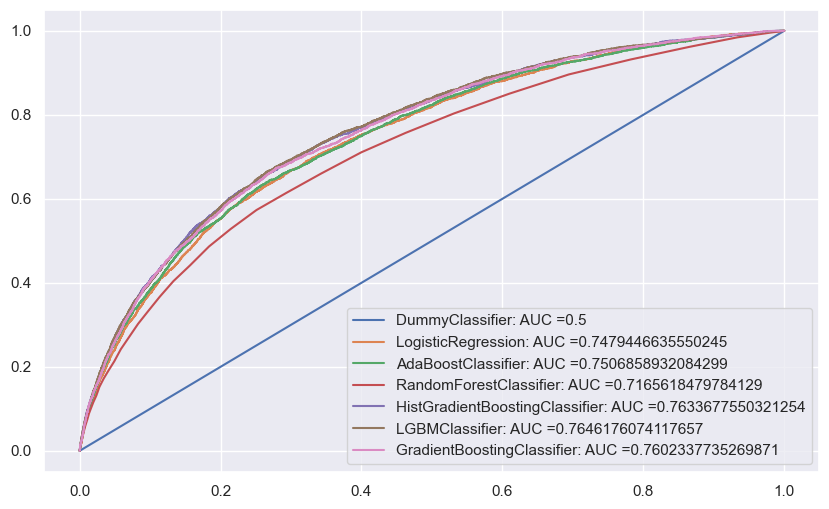

In [281]:
generate_auc_roc_curve(dummy_pipe,X_test,y_test)
generate_auc_roc_curve(reg_raw_pipe,X_test,y_test)
generate_auc_roc_curve(Ada_pipe,X_test,y_test)
generate_auc_roc_curve(RF_pipe,X_test,y_test)
generate_auc_roc_curve(HistGB_pipe,X_test,y_test)
generate_auc_roc_curve(LGBM_pipe,X_test,y_test)
generate_auc_roc_curve(GradientBoosting_pipe,X_test,y_test)


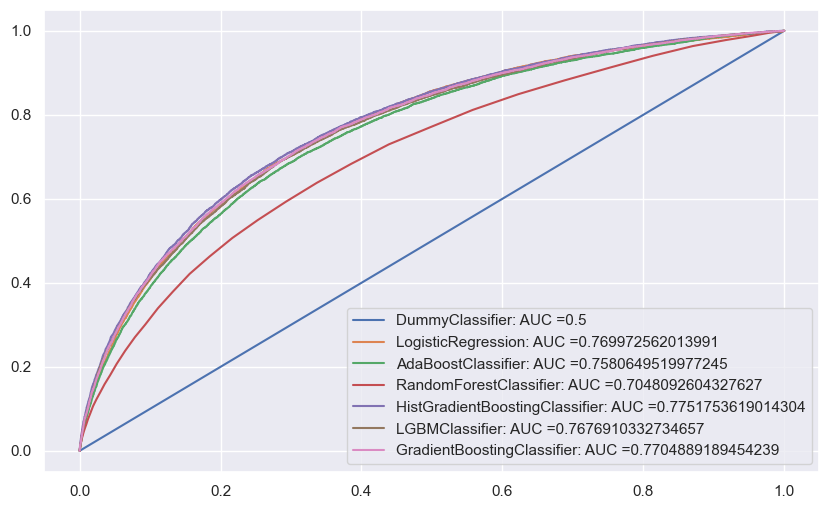

### <a name="C4"><font color='purple'>4. Sauvegarde des models</font></a>

In [282]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")
joblib.dump(reg_raw_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")
joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")
joblib.dump(GradientBoosting_pipe,"data/modeles sauvegardés/GradientBoostingClassifier_model.sav")

['data/modeles sauvegardés/GradientBoostingClassifier_model.sav']

In [283]:
gc.collect()

51314

### <a name="C5"><font color='blue'>5. MLflow</font></a>

In [91]:
import mlflow
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [ ]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

In [ ]:
#mlflow.set_tracking_uri("file:///Users/mah/mlruns")

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
mlflow.set_experiment('OC DS P7_Model Implémentez un modèle de scoring') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog()# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

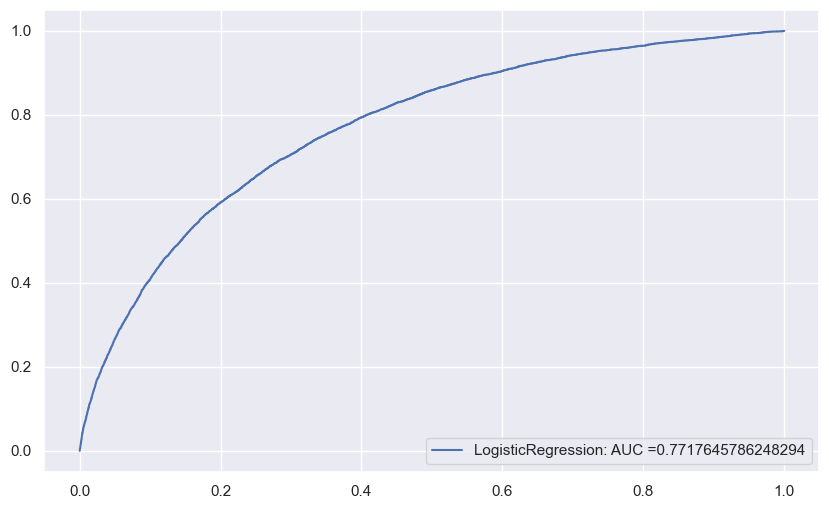

In [94]:
# premier run
with mlflow.start_run(run_name='Reg_logistic_defaut'):
    logisReg = LogisticRegression()
    logisReg.fit(X_train_processed,y_train)
    
    y_pred = logisReg.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy',acc)
    mlflow.log_metric('precision',prec)
    mlflow.log_metric('recall',recall)
    mlflow.log_metric('F1',f1)
    mlflow.log_metric('AUC',auc)
    mlflow.sklearn.log_model(logisReg, 'RegLogistic_defaut')
    generate_auc_roc_curve(logisReg,X_test_processed,y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

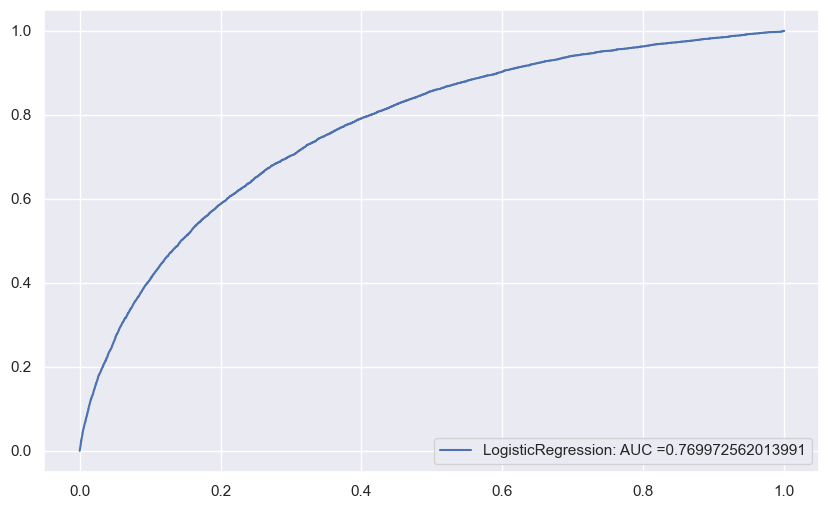

In [95]:
# deuxieme run
with mlflow.start_run(run_name='Reg_logistic_max_iter20000'):
    logisReg2 = LogisticRegression(max_iter = 20000)
    logisReg2.fit(X_train_processed,y_train)
    
    y_pred = logisReg2.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy_test',acc)
    mlflow.log_metric('precision_test',prec)
    mlflow.log_metric('recall_test',recall)
    mlflow.log_metric('F1_test',f1)
    mlflow.log_metric('AUC_test',auc)
    mlflow.sklearn.log_model(logisReg2, 'RegLogistic_max_iter20000')
    generate_auc_roc_curve(logisReg2,X_test_processed,y_test)

In [ ]:
# best param run
with mlflow.start_run(run_name='Reg_logistic_best_param'):
    logisReg = LogisticRegression()
    logisReg.fit(X_train_processed,y_train)
    
    y_pred = logisReg.predict(X_test_processed)

    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    recall = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    mlflow.log_metric('accuracy_test',acc)
    mlflow.log_metric('precision_test',prec)
    mlflow.log_metric('recall_test',recall)
    mlflow.log_metric('F1_test',f1)
    mlflow.log_metric('AUC_test',auc)
    mlflow.sklearn.log_model(logisReg, 'RegLogistic_defaut')
    generate_auc_roc_curve(logisReg,X_test_processed,y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>